In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load CSVs
import pandas as pd

pairs_with_similarity_path = '/content/drive/MyDrive/Pairs_with_Similarity_Combined.csv'
partially_oversampled_path = '/content/drive/MyDrive/Partially_Oversampled_Data.csv'

example_data = pd.read_csv(pairs_with_similarity_path)
df2 = pd.read_csv(partially_oversampled_path)

Mounted at /content/drive


/tmp/ipython-input-2125043706.py:11: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(partially_oversampled_path)


ADASYN Oversample

In [ ]:
#pip install imbalanced-learn
target_interaction_indices = {55, 121, 56, 47, 73, 59, 105, 102, 37, 48, 22, 32, 43, 81}

target_data = example_data[example_data['interaction'].isin(target_interaction_indices)]
non_target_data = example_data[~example_data['interaction'].isin(target_interaction_indices)]

X_target = target_data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
X_target = X_target.astype('float32')  # 
y_target = target_data['interaction']

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_target, y_target)

resampled_target_df = pd.DataFrame(X_resampled, columns=X_target.columns)
resampled_target_df['interaction'] = y_resampled

final_resampled_df = pd.concat([non_target_data, resampled_target_df], ignore_index=True)

final_resampled_df.to_csv(
    "/content/drive/MyDrive/Partially_ADASYN_Resampled_Data.csv",
    index=False
)

print("Resampled dataset saved in Google Drive as 'Partially_ADASYN_Resampled_Data.csv'")


/tmp/ipython-input-1957304815.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_target_df['interaction'] = y_resampled


Resampled dataset saved in Google Drive as 'Partially_ADASYN_Resampled_Data.csv'


In [ ]:
import pandas as pd
from google.colab import files
import shutil

# 1.  /content
csv_path = "/content/Partially_ADASYN_Resampled_Data.csv"
final_resampled_df.to_csv(csv_path, index=False)

# 2.  zip
zip_path = "/content/Partially_ADASYN_Resampled_Data.zip"
shutil.make_archive("/content/Partially_ADASYN_Resampled_Data", 'zip', root_dir="/content", base_dir="Partially_ADASYN_Resampled_Data.csv")

# 3.  zip 
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dataset with ASADYN——DNN Test

In [ ]:
# --------------------------
#  Import libraries
# --------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from google.colab import drive

# --------------------------
#  Mount Google Drive
# --------------------------
drive.mount('/content/drive')

# --------------------------
#  Load dataset
# --------------------------
data_path = '/content/drive/MyDrive/Partially_Oversampled_Data.csv'
data = pd.read_csv(data_path)

# --------------------------
#  Define DNN model
# --------------------------
class DNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# --------------------------
# Repeated training with cost-sensitive loss
# --------------------------
repeat_times = 5
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

for run in range(repeat_times):
    print(f"\n======  Run {run+1}/{repeat_times} ======")

    # ---------- Data preprocessing ----------
    X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
    y = data['interaction']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42+run, stratify=y
    )

    # ---------- Tensors ----------
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    batch_size = 512
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                             batch_size=batch_size, shuffle=False)

    # ---------- Class weights ----------
    class_counts = y_train.value_counts().sort_index()
    class_weights = (len(y_train) / (len(class_counts) * class_counts)).values
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # ---------- Model setup ----------
    model = DNNModel(X_train_tensor.shape[1], len(y.unique())).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0025)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=10, factor=0.5
    )

    # ---------- Training loop ----------
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_threshold = 15
    epochs = 300

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
        val_loss /= len(test_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_threshold:
            break

    # ---------- Evaluation ----------
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_tgts.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_tgts, all_preds)
    f1 = f1_score(all_tgts, all_preds, average='weighted', zero_division=0)
    prec = precision_score(all_tgts, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_tgts, all_preds, average='weighted', zero_division=0)
    results.append([acc, f1, prec, rec])

# --------------------------
#  Show mean ± sd
# --------------------------
results = np.array(results)
metrics = ["Accuracy", "F1", "Precision", "Recall"]
print("\n Cost-Sensitive DNN Results (mean ± sd):")
for i, m in enumerate(metrics):
    print(f"{m}: {results[:,i].mean():.4f} ± {results[:,i].std():.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1647597458.py:24: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


✅ Using device: cuda

====== 🔁 Run 1/5 ======

====== 🔁 Run 2/5 ======

====== 🔁 Run 3/5 ======

====== 🔁 Run 4/5 ======

====== 🔁 Run 5/5 ======

📌 Cost-Sensitive DNN Results (mean ± sd):
Accuracy: 0.5221 ± 0.0149
F1: 0.4841 ± 0.0169
Precision: 0.5707 ± 0.0189
Recall: 0.5221 ± 0.0149


Attention

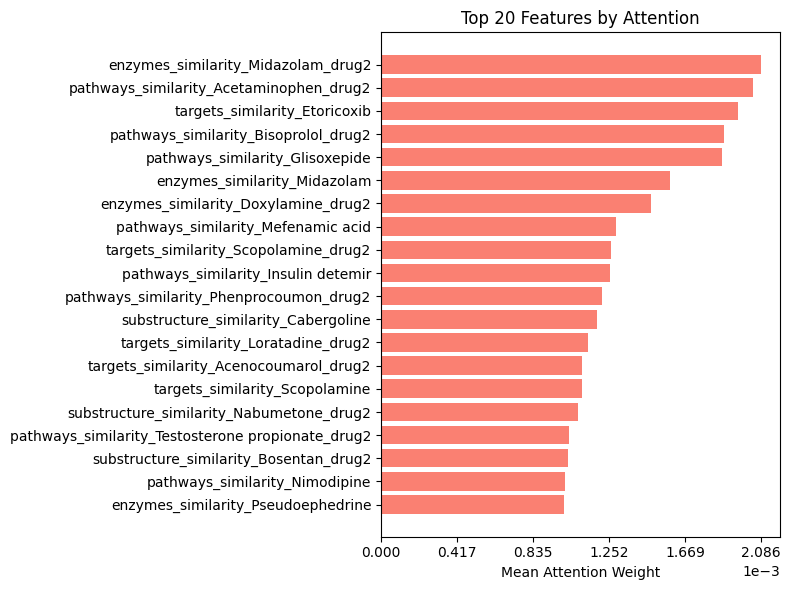

📊 Attention visualization saved as 'attention_top20.png'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --------------------------
#  Import libraries
# --------------------------
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from google.colab import drive, files
import matplotlib.pyplot as plt

# --------------------------
#  Mount Google Drive
# --------------------------
drive.mount('/content/drive')

# --------------------------
#  Load dataset
# --------------------------
data_path = '/content/drive/MyDrive/Partially_Oversampled_Data.csv'
data = pd.read_csv(data_path)

# --------------------------
#  Data preprocessing
# --------------------------
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------
#  Move data to tensors
# --------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# --------------------------
#  Create DataLoader
# --------------------------
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --------------------------
#  Device
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# --------------------------
#  Define Feature-level Attention DNN
# --------------------------
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)  # 
        )

    def forward(self, x):
        # x shape: (batch, features)
        attn_weights = torch.softmax(self.attention(x), dim=1)  #  softmax
        attended_x = x * attn_weights  # 
        return attended_x, attn_weights

class AttentionDNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AttentionDNN, self).__init__()
        self.attention = AttentionLayer(input_size, 64)
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        attended_x, attn_weights = self.attention(x)
        out = self.fc(attended_x)
        return out, attn_weights

input_size = X_train_tensor.shape[1]
num_classes = len(y.unique())
model = AttentionDNN(input_size, num_classes).to(device)

# --------------------------
# Loss, Optimizer, Scheduler
# --------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0025)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=10, factor=0.5
)

# --------------------------
# ️ Training Loop with Early Stopping
# --------------------------
epochs = 100
early_stopping_threshold = 15
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs, _ = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs, _ = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f" Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

# --------------------------
#  Evaluation
# --------------------------
model.eval()
all_predictions, all_targets, all_probs, all_attentions = [], [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, attn_weights = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(probs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())
        all_attentions.extend(attn_weights.cpu().numpy())

accuracy = accuracy_score(all_targets, all_predictions)
f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)
precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)

print("\n Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# --------------------------
#  Save results
# --------------------------
results_dict = {
    "Method": "AttentionDNN",
    "Accuracy": accuracy,
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
    "y_true": np.array(all_targets),
    "y_pred_prob": np.array(all_probs),
    "attention_weights": np.array(all_attentions)
}

with open('attention_dnn_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print(" Results exported to 'attention_dnn_results.pkl'")
files.download('attention_dnn_results.pkl')

mean_attn = np.mean(np.array(all_attentions), axis=0)

# Top-20 
top_n = 20
indices = np.argsort(mean_attn)[-top_n:][::-1]
top_features = [X.columns[i] for i in indices]
top_weights = mean_attn[indices]

# 
plt.figure(figsize=(8,6))
plt.barh(top_features[::-1], top_weights[::-1], color="salmon")
plt.xlabel("Mean Attention Weight")
plt.title(f"Top {top_n} Features by Attention")

#   x 
plt.xticks(np.linspace(0, max(top_weights), 6))  #  6 
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  # 
plt.tight_layout()
plt.savefig("attention_top20.png", dpi=300)
plt.show()

print(" Attention visualization saved as 'attention_top20.png'")
files.download("attention_top20.png")